# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

#### #Convert the edf file into csv and reload the csv file

If we just use raw_data[0], just as the we mentioned above, this step will not be needed anymore

In [1]:
import numpy as np

In [2]:
import pandas as pd
ppg = pd.read_csv('BVP.csv')

In [3]:
ppg

,1563898771.00
0,64.00
1,-0.00
2,-0.00
3,-0.00
4,-0.00
...,...
145295,155.35
145296,133.95
145297,114.88
145298,97.94


In [4]:
np.savetxt('ppg.txt',ppg)

#### Plot the signal to explore the data

In [5]:
sampling_freq = 1/64  #This is the sampling frequency
N = ppg.size  #The number of point
N

145300

In [6]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N) #Set the time sequence for the signal
index

array([0.00000000e+00, 1.56250002e-02, 3.12500003e-02, ...,
       2.27026565e+03, 2.27028127e+03, 2.27029690e+03])

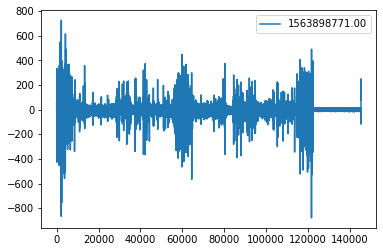

In [7]:
ppg.plot()

In [8]:
ppg_array = ppg.to_numpy() #save the data into an ndarray
ppg_array.size

145300

#### Truncate the signal 
Get rid of the first 3mins and last 5mins

In [9]:
ppg_array = ppg_array[0:121000]  # Remove the signal in first 3minutes and last 5minutes

In [10]:
ppg_array.size

121000

In [11]:
sampling_freq = 1/64
N = ppg_array.size

In [12]:
index = np.linspace(0, round((N-1)*sampling_freq,4), N)
index

array([0.00000000e+00, 1.56250002e-02, 3.12500004e-02, ...,
       1.89057815e+03, 1.89059377e+03, 1.89060940e+03])

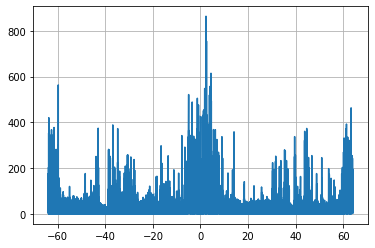

In [13]:
from scipy.fft import fft,fftshift
# Number of sample points

y = ppg_array
yf = fft(y)
yf = fftshift(yf)
xf = np.linspace(-1/sampling_freq, 1/sampling_freq, N)
import matplotlib.pyplot as plt
plt.plot(xf, np.abs(yf))
#plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

#### Ideal filter

The result shows that the ideal filter will introduce some baseline drift, so we plan to use butterworth filter later

#### Butterworth Band pass Filter

In [14]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

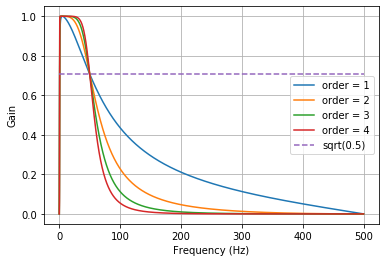

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

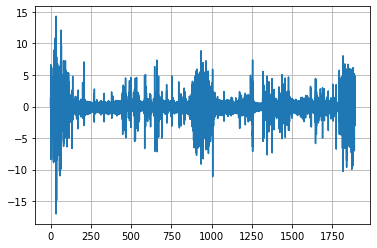

In [16]:
y = butter_bandpass_filter(ppg_array, lowcut, highcut, fs, order=2)
plt.plot(index, y, label='Filtered signal (Hz)')
plt.grid(True)
plt.show()

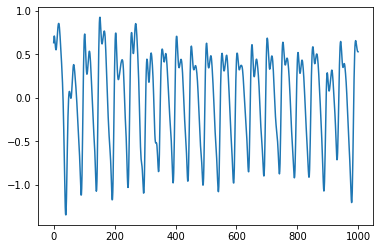

In [17]:
recover_ECG_example = y[20000:21000]
plt.plot(recover_ECG_example)
plt.show()

From the original signal, we could see that the T wave is much higher than P wave. Butterworth filter with order=2 could show this feature sucessfully. However, with order=3 and order=4, the difference between T wave and P wave are decreased.

#### Resampling

For PPG, it's not so necessary to resample the signal because the sample frequency of the original signal is 64Hz. But in order to SVD, we need to approximate the signal into a squared number

In [18]:
N

121000

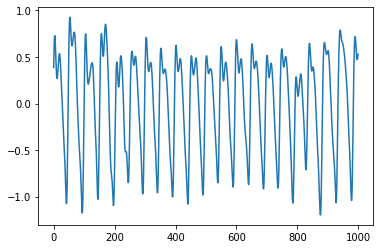

In [19]:
from scipy import signal
y = butter_bandpass_filter(ppg_array, lowcut, highcut, fs, order=2)
resampled_signal = signal.resample(y,120409 )  #This squared number need to be decided by the users
plt.plot(resampled_signal[20000:21000])
plt.show()

#### Amplitude Normalization

For the ppg signal, it's not necessary to do normalization, so we can just skip this step

In [20]:
#def NormalizeData(data):
#    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [21]:
#normalized_signal = NormalizeData(resampled_signal)
#norm1 = x / np.linalg.norm(x)
#norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
#plt.plot(normalized_signal[74000:76000])
#plt.show()

#### SVD

In [59]:
from scipy import linalg
reshaped_signal = np.reshape(resampled_signal, (347,347))
U, s, Vh = linalg.svd(reshaped_signal)
print(reshaped_signal.shape)
print(U.shape)
print(s.shape)
print(Vh.shape)

(347, 347)
(347, 347)
(347,)
(347, 347)


In [60]:
s[75:] = 0

In [61]:
m = 347
n = 347
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = s[i]
reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
deSVD = np.reshape(reconstructed_signal,347*347)

In [62]:
np.savetxt('deSVD_ppg.txt',deSVD,fmt='%.4f')

In [63]:
decoded_data = np.loadtxt(fname = "deSVD_ppg.txt")

In [64]:
decoded_data.shape

(120409,)

In [65]:
decoded_data =decoded_data[..., np.newaxis]

In [66]:
resampled_signal.shape

(120409, 1)

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, decoded_data)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 1.747%


CR = 3.7*1024/400 = 9.47

#### Reconstruct the original matrix from the decomposition
For future decoding

In [ ]:
# Kernal need 
#m = 347
#n = 347
#sigma = np.zeros((m, n))
#for i in range(min(m, n)):
#    sigma[i, i] = s[i]
#reconstructed_signal = np.dot(U, np.dot(sigma, Vh))
#reshaped_recon_signal = np.reshape(reconstructed_signal,120409)
#np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

#### Quantization

In [ ]:
round_U = np.around(U,4) #Keep four decimals
print(round_U)
unique, counts = np.unique(round_U, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

In [ ]:
np.savetxt('ppg_U_round4.txt',round_U,fmt='%.3f')

#### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr <filename>.txt" / "tcmpr <filepath>" to compress the file
4. Find the compressed file in the same directory of the original file



1. The file size(round 4) before Huffman coding is 782KB. The file size(round 4) after Huffman coding is 302kB



Also do this step for "s" and "Vh"

In [ ]:
round_s = np.around(s,4)
unique, counts = np.unique(round_s, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

In [ ]:
np.savetxt('ppg_s_round4.txt',round_s,fmt='%.3f')

In [ ]:
plt.plot(round_s)

"s" can be shrank from 2kb to 961bytes

In [ ]:
round_Vh = np.around(Vh,4)
#print(round_s)
unique, counts = np.unique(round_Vh, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

In [ ]:
np.savetxt('ppg_Vh_round4.txt',round_Vh,fmt='%.3f')

"Vh" can be shrank from 782kB to 304kB

In conclusion, the size of the original data in csv is 902kB. In txt file, the size of the original data is 3.7MB. After compression, the size of the U, s, and Vh is 302kB, 0.94KB, and 304kB. The compression ratio is 6.24.
It seems that the compression result is not so ideal as we supposed. Also, the SVD decomposed the data into 3 matrices, but it actually expand the size/length of the data. So I was thinking.....

#### PRD calculation

In [ ]:
decoded_data_U = np.loadtxt(fname = "ppg_U_round4.txt") #Cuz Huffman coding is lossless coding, so it's fine to use this txt file
decoded_data_s = np.loadtxt(fname = "ppg_s_round4.txt")
decoded_data_Vh = np.loadtxt(fname = "ppg_Vh_round4.txt")
#decoded_data_U =decoded_data_U[..., np.newaxis]
#decoded_data_s =decoded_data_s[..., np.newaxis]
#decoded_data_Vh =decoded_data_Vh[..., np.newaxis]

In [ ]:
s.shape

In [ ]:
# Kernal need 
m = 347
n = 347
sigma = np.zeros((m, n))
for i in range(min(m, n)):
    sigma[i, i] = decoded_data_s[i]
reconstructed_signal = np.dot(decoded_data_U, np.dot(sigma, decoded_data_Vh))
deSVD = np.reshape(reconstructed_signal,120409)
#np.allclose(reshaped_recon_signal, normalized_signal)
#True means the signal could be reconstructed back to the original one

In [ ]:
deSVD = deSVD[..., np.newaxis]

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, deSVD)
print("The PRD is {}%".format(round(PRD*100,3)))

### What if I don't do SVD? Just compress the signal directly...

In [ ]:
round_signal = np.around(resampled_signal,2) #round it with 2 decimals will be good
#Cuz keep only 1 decimal will lose a lot of information, and keep 3 decimals will be redundant 
#and the compression ratio will not be good.
print(round_signal)
unique, counts = np.unique(round_signal, return_counts=True)
U_dict = dict(zip(unique, counts))
unique.size

In [ ]:
plt.plot(round_signal[74000:76000])
plt.show()

In [ ]:
np.savetxt('ppg_signal_rounded.txt',round_signal,fmt='%.3f')

In [ ]:
decoded_data = np.loadtxt(fname = "ppg_signal_rounded.txt")

In [ ]:
decoded_data

In [ ]:
plt.plot(decoded_data[74000:76000])
plt.show()

In [ ]:
decoded_data.shape

Use Huffman coding to encode this normalized signal sequence.

Before Huffman coding, the size of the txt file of this signal sequence is 778kB. After Huffman coding, the size of the txt file of this signal sequence is 307kB.

The original size of the raw data is 902kB in csv and 3.7MB in txt. If we calculate the compression ratio by the same data format. The compression ratio is 12.34


In [ ]:
resampled_signal.shape

In [ ]:
resampled_signal

In [ ]:
decoded_data

In [ ]:
decoded_data =decoded_data[..., np.newaxis]
decoded_data

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
sqrt(sum((resampled_signal-decoded_data)**2)/(sum(resampled_signal**2)))

#### PRD calculation:


In [ ]:
#resampled_signal_ori = signal.resample(ECG_array, 564001)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal, decoded_data)
print("The PRD is {}%".format(round(PRD*100,3)))

### Instructions

Put instructions of how to use your method here.

More instruction needs to be well documented

Dependencies: 

All codes based on Python3
Numpy, Pandas, tcmpr 0.2 installed on the users' system

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | 17 | 0.949% |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |

In [ ]:
import pandas as pd
PPG = pd.read_csv('BVP.csv')

In [ ]:
PPG.size